# Install libraries

In [ ]:
#installations
%pip install python-dotenv
%pip install langchain
%pip install langchain_ibm
%pip install langchain_core
%pip install langgraph
%pip install nasapy

# Imports

In [ ]:
#imports
from nasapy import Nasa
from langchain_ibm import ChatWatsonx
from langchain_core.tools import tool
from langchain_core.messages import AnyMessage, HumanMessage, ToolMessage
from langgraph.graph import StateGraph, END
from datetime import datetime, timedelta
from operator import add
from typing import Annotated
from typing_extensions import TypedDict
from IPython.display import Image, display

# Setup Credentials and Model Parameters 

In [ ]:
# credentials
credentials = {
    "url": "WATSONX_URL",
    "apikey": "WATSONX_API_KEY",
    "project_id": "PRJ_ID"
}

# params
params = {
    "decoding_method": "greedy",
    "temperature": 0, 
    "min_new_tokens": 5,
    "max_new_tokens": 250,
    "stop_sequences":['\n\n']
}

# model
llm = ChatWatsonx(
    model_id =  "mistralai/mistral-large",
	url = credentials.get("url"),
	apikey = credentials.get("apikey"),
	project_id =  credentials.get("project_id"),
	params = params
)

# Setup NASA API Key
Generate one on the [NASA website](https://api.nasa.gov)

In [ ]:
# add your nasa api key
n = Nasa(key="NASA_API_KEY")
n.picture_of_the_day("2025-01-19")

{'date': '2025-01-19',
 'explanation': "What would it look like to land on Saturn's moon Titan? The European Space Agency's Huygens probe set down on the Solar System's cloudiest moon in 2005, and a time-lapse video of its descent images was created. Huygens separated from the robotic Cassini spacecraft soon after it achieved orbit around Saturn in late 2004 and began approaching Titan. For two hours after arriving, Huygens plummeted toward Titan's surface, recording at first only the shrouded moon's opaque atmosphere. The computerized truck-tire sized probe soon deployed a parachute to slow its descent, pierced the thick clouds, and began transmitting images of a strange surface far below never before seen in visible light. Landing in a dried sea and surviving for 90 minutes, Huygen's returned unique images of a strange plain of dark sandy soil strewn with smooth, bright, fist-sized rocks of ice.",
 'media_type': 'video',
 'service_version': 'v1',
 'title': 'Titan Touchdown: Huygens D

# Define Tools for the Agent

In [5]:
# tools

@tool
def get_todays_date() -> str:
    """Get today's date in YYYY-MM-DD format.
    """
    date = datetime.now().strftime("%Y-%m-%d")
    return date

@tool(return_direct=True)
def get_astronomy_image(date_of_picture: str) -> str:
    """Get NASA's Astronomy Picture of the Day on given date.
    
    Args:
        date_of_picture: the date for the picture of the day.
    """
    apod = n.picture_of_the_day(date_of_picture, hd=True)
    return apod['url']

tools = [get_todays_date, get_astronomy_image]
tools_names = {t.name: t for t in tools}
llm_with_tools = llm.bind_tools(tools)

# Define the LangGraph agent

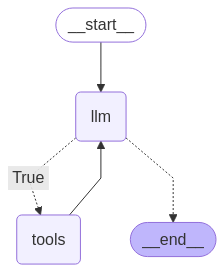

In [6]:
# state class
class State(TypedDict):
  messages: Annotated[list[AnyMessage], add]

def execute_tools(state: State):
    tool_calls = state['messages'][-1].tool_calls
    results = []
    for t in tool_calls:
      if not t['name'] in tools_names:
        result = "Error: There's no such tool, please try again"
      else:
        result = tools_names[t['name']].invoke(t['args'])
        results.append(
          ToolMessage(
            tool_call_id=t['id'],
            name=t['name'],
            content=str(result)
          )
        )
    return {'messages': results}

def tool_exists(state: State):
    result = state['messages'][-1]
    return len(result.tool_calls) > 0
    
# func to add node
def run_llm(state: State):
    messages = state['messages']
    message = llm_with_tools.invoke(messages)
    return {'messages': [message]}

# create the agent graph
graph_builder=StateGraph(State)
graph_builder.add_node("llm", run_llm)
graph_builder.add_node("tools", execute_tools)
graph_builder.add_conditional_edges(
    "llm",
     tool_exists,
    {True: "tools", False: END}
    )

graph_builder.add_edge("tools", "llm")

graph_builder.set_entry_point("llm")

graph=graph_builder.compile()

# print the graph
display(Image(graph.get_graph().draw_mermaid_png()))

In [7]:
# Test the graph
messages = [HumanMessage(content="Tell me a joke about mathematics")]
result = graph.invoke({"messages": messages})
print(result)

{'messages': [HumanMessage(content='Tell me a joke about mathematics', additional_kwargs={}, response_metadata={}), AIMessage(content=' What does the zero say to the eight? Nice belt.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 13, 'prompt_tokens': 167, 'total_tokens': 180}, 'model_name': 'mistralai/mistral-large', 'system_fingerprint': '', 'finish_reason': 'stop'}, id='chatcmpl-14e1bdacf9f495eccb577ed84918ae59', usage_metadata={'input_tokens': 167, 'output_tokens': 13, 'total_tokens': 180})]}


# Test Agent

In [8]:
# handle printouts
def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()

In [9]:
# test1
messages = [HumanMessage(content="What is today's date?")]
print_stream(graph.stream({"messages": messages}, stream_mode="values"))

================================ Human Message =================================

What is today's date?
================================== Ai Message ==================================
Tool Calls:
  get_todays_date (9LFXFzRPy)
 Call ID: 9LFXFzRPy
  Args:
================================= Tool Message =================================
Name: get_todays_date

2025-04-30
================================== Ai Message ==================================

 Today's date is 2025-04-30. Would you like to see NASA's Astronomy Picture of the Day for today?


In [11]:
messages = [HumanMessage(content="What is NASA's Astronomy Picture of the Day for today?")]
print_stream(graph.stream({"messages": messages}, stream_mode="values"))

================================ Human Message =================================

What is NASA's Astronomy Picture of the Day for today?
================================== Ai Message ==================================
Tool Calls:
  get_todays_date (eZ92MiRFM)
 Call ID: eZ92MiRFM
  Args:
================================= Tool Message =================================
Name: get_todays_date

2025-04-30
================================== Ai Message ==================================
Tool Calls:
  get_astronomy_image (0oniEX7bC)
 Call ID: 0oniEX7bC
  Args:
    date_of_picture: 2025-04-30
================================= Tool Message =================================
Name: get_astronomy_image

https://apod.nasa.gov/apod/image/2504/HappySkyMexico_Korona_960.jpg
================================== Ai Message ==================================

 Here is the Astronomy Picture of the Day for today:

![Astronomy Picture of the Day](https://apod.nasa.gov/apod/image/2504/HappySkyMexico_Korona_960.jp

In [12]:
messages = [HumanMessage(content="Show me NASA's Astronomy Picture using the date from 2 days ago.")]
print_stream(graph.stream({"messages": messages}, stream_mode="values"))

================================ Human Message =================================

Show me NASA's Astronomy Picture using the date from 2 days ago.
================================== Ai Message ==================================
Tool Calls:
  get_todays_date (BkeNdF2vn)
 Call ID: BkeNdF2vn
  Args:
================================= Tool Message =================================
Name: get_todays_date

2025-04-30
================================== Ai Message ==================================
Tool Calls:
  get_astronomy_image (RYdV6hNKl)
 Call ID: RYdV6hNKl
  Args:
    date_of_picture: 2025-04-28
================================= Tool Message =================================
Name: get_astronomy_image

https://apod.nasa.gov/apod/image/2504/Gum37Hoo_Bozon_960.jpg
================================== Ai Message ==================================

 Here is the NASA's Astronomy Picture of the Day from 2025-04-28:

![Astronomy Picture of the Day](https://apod.nasa.gov/apod/image/2504/Gum37Hoo_Boz